<a href="https://colab.research.google.com/github/ChinmayMundane/husky_env/blob/main/husky_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <h1><center>MJX Tutorial  <a href="https://colab.research.google.com/github/patsyuk03/MJX_Tutorial/blob/main/MJX_Tutorial.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" width="140" align="center"/></a></center></h1>

In [30]:
#@title Install MuJoCo and MJX
!pip install mujoco
!pip install mujoco_mjx

/usr/lib/python3.12/pty.py:95: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [31]:
#@title Check if MuJoCo installation was successful

# from google.colab import files

# import distutils.util
import os
import subprocess
if subprocess.run('nvidia-smi').returncode:
  raise RuntimeError(
      'Cannot communicate with GPU. '
      'Make sure you are using a GPU Colab runtime. '
      'Go to the Runtime menu and select Choose runtime type.')

# Add an ICD config so that glvnd can pick up the Nvidia EGL driver.
# This is usually installed as part of an Nvidia driver package, but the Colab
# kernel doesn't install its driver via APT, and as a result the ICD is missing.
# (https://github.com/NVIDIA/libglvnd/blob/master/src/EGL/icd_enumeration.md)
NVIDIA_ICD_CONFIG_PATH = '/usr/share/glvnd/egl_vendor.d/10_nvidia.json'
if not os.path.exists(NVIDIA_ICD_CONFIG_PATH):
  with open(NVIDIA_ICD_CONFIG_PATH, 'w') as f:
    f.write("""{
    "file_format_version" : "1.0.0",
    "ICD" : {
        "library_path" : "libEGL_nvidia.so.0"
    }
}
""")

# Configure MuJoCo to use the EGL rendering backend (requires GPU)
print('Setting environment variable to use GPU rendering:')
%env MUJOCO_GL=egl

try:
  print('Checking that the installation succeeded:')
  import mujoco
  mujoco.MjModel.from_xml_string('<mujoco/>')
except Exception as e:
  raise e from RuntimeError(
      'Something went wrong during installation. Check the shell output above '
      'for more information.\n'
      'If using a hosted Colab runtime, make sure you enable GPU acceleration '
      'by going to the Runtime menu and selecting "Choose runtime type".')

print('Installation successful.')

# Tell XLA to use Triton GEMM, this improves steps/sec by ~30% on some GPUs
xla_flags = os.environ.get('XLA_FLAGS', '')
xla_flags += ' --xla_gpu_triton_gemm_any=True'
os.environ['XLA_FLAGS'] = xla_flags

Thu Jul  3 15:55:39 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.230.02             Driver Version: 535.230.02   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4090        Off | 00000000:02:00.0  On |                  Off |
| 30%   28C    P8              15W / 450W |   1293MiB / 24564MiB |     24%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [39]:
#@title Import packages for plotting and creating graphics
import time
import numpy as np

# Graphics and plotting.
print('Installing mediapy:')
!command -v ffmpeg >/dev/null || (apt update && apt install -y ffmpeg)
!pip install -q mediapy
import mediapy as media
import matplotlib.pyplot as plt

Installing mediapy:


/usr/lib/python3.12/pty.py:95: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [ ]:
#@title Clone GitHub repository with MJX Tutorial
import os



os.chdir('/home/alinjar/husky_env')

print(os.getcwd())


Changed dir: /home/alinjar/husky_env
/home/alinjar/husky_env


In [7]:
#@title Other Imports

import mujoco
import mujoco.mjx as mjx
import jax
import jax.numpy as jnp
from functools import partial

# import mujoco
# import mujoco.mjx as mjx
# import jax
# import jax.numpy as jnp
# from functools import partial
# import os
# import time
# import numpy as np
# import mediapy as media
# import matplotlib.pyplot as plt

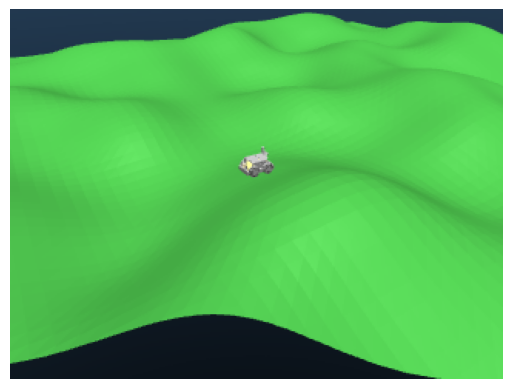

In [24]:
#@title Initialize Mujoco Model, Data and Renderer

model_path = f"{os.getcwd()}/default3.xml"

# Load the MuJoCo model
model = mujoco.MjModel.from_xml_path(model_path)
model.opt.timestep = 0.002  # Set timestep as defined in the XML

# Initialize MuJoCo data
data = mujoco.MjData(model)

# Set initial joint positions (qpos) for the free joint of the base and wheel joints
# syntax for husk is qpos: [x, y, z, qw, qx, qy, qz, front_left, front_right, rear_left, rear_right]
data.qpos = jnp.array([0.0, 0.0, 2.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])

# Perform a forward dynamics step to update the scene
mujoco.mj_forward(model, data)

# Initialize the renderer
renderer = mujoco.Renderer(model)

# Set up a free camera to view the terrain and vehicle
camera = mujoco.MjvCamera()
camera.lookat[:] = [0.0, 0.0, 1.0]  # Look center
camera.distance = 15.0  # z
camera.azimuth = -120
camera.elevation = -30

# Configure scene options
scene_option = mujoco.MjvOption()
scene_option.sitegroup[:] = False
scene_option.sitegroup[1] = True  # Enable visualization of group 1 (visual geoms)

# Update the scene and render
renderer.update_scene(data, scene_option=scene_option, camera=camera)
pixels = renderer.render()

# Display the rendered image
plt.imshow(pixels)
plt.axis('off')
plt.show()



In [44]:
import mujoco
import mujoco.mjx as mjx
import jax
import jax.numpy as jnp
import numpy as np
import mediapy as media
import time
import os
from functools import partial


os.environ["JAX_PLATFORM_NAME"] = "gpu"  # Ensure GPU usage

class Simulator:
    def __init__(self, model, data, num_dof=2, num_batch=1, num_steps=50):
        self.num_dof = num_dof
        self.num_batch = num_batch
        self.num_steps = num_steps
        self.model = model
        self.mjx_model = mjx.put_model(model)
        self.mjx_data = mjx.put_data(model, data)
        self.jit_step = jax.jit(mjx.step)
        self.base_id = model.body(name="robot0:base_link").id
        self.compute_rollout_batch = jax.vmap(self.compute_rollout_single, in_axes=(0,))
        self.compute_cost_batch = jax.vmap(self.compute_cost_single, in_axes=(0, 0))

    @partial(jax.jit, static_argnums=(0,))
    def compute_cost_single(self, base_pos, base_angvel):
        target_x = 2.0
        cost_pos = jnp.linalg.norm(base_pos[-1, 0] - target_x)
        cost_angvel = jnp.sum(jnp.abs(base_angvel))
        cost = 1.0 * cost_pos + 0.1 * cost_angvel
        return cost

    @partial(jax.jit, static_argnums=(0,))
    def mjx_step(self, mjx_data, ctrl_single):
        ctrl_single = jnp.clip(ctrl_single, -8.0, 8.0)
        mjx_data = mjx_data.replace(ctrl=mjx_data.ctrl.at[:self.num_dof].set(ctrl_single))
        mjx_data = self.jit_step(self.mjx_model, mjx_data)
        base_pos = mjx_data.xpos[self.base_id]
        base_angvel = mjx_data.cvel[self.base_id, 3:6]
        return mjx_data, (base_pos, base_angvel)

    @partial(jax.jit, static_argnums=(0,))
    def compute_rollout_single(self, ctrl):
        mjx_data = self.mjx_data
        ctrl_single = ctrl.reshape(self.num_dof, self.num_steps)
        _, out = jax.lax.scan(self.mjx_step, mjx_data, ctrl_single.T, length=self.num_steps)
        base_pos, base_angvel = out
        return base_pos, base_angvel

    @partial(jax.jit, static_argnums=(0,))
    def get_best_traj(self, ctrl):
        base_pos, base_angvel = self.compute_rollout_batch(ctrl)
        cost_batch = self.compute_cost_batch(base_pos, base_angvel)
        idx_min = jnp.argmin(cost_batch)
        cost = jnp.min(cost_batch)
        best_traj = ctrl[idx_min].reshape((self.num_dof, self.num_steps)).T
        return cost, best_traj, base_pos, base_angvel


# Initialize model and data
model_path = f"{os.getcwd()}/default3.xml"
model = mujoco.MjModel.from_xml_path(model_path)
model.opt.timestep = 0.02
data = mujoco.MjData(model)
data.qpos = jnp.array([0.0, 0.0, 2.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])

# Initialize simulator
num_dof = 2
num_batch = 100
num_steps = 50
sim = Simulator(model=model, data=data, num_dof=num_dof, num_batch=num_batch, num_steps=num_steps)

# Generate control inputs
key = jax.random.PRNGKey(0)

# Action 1: Only forward
forward_vel = jnp.full((num_batch, num_steps), 8.0)
turn_vel = jnp.full((num_batch, num_steps), 0.0)

# Choose other actions by uncommenting one:
# Action 2: Turn left (little skidding)
# forward_vel = jnp.full((num_batch, num_steps), 0.0)
# turn_vel = jnp.full((num_batch, num_steps), 8.0)

# Action 3: Turn left (with some forward)
# forward_vel = jnp.full((num_batch, num_steps), 5.0)
# turn_vel = jnp.full((num_batch, num_steps), 8.0)

# Action 4: Random
# forward_vel = jax.random.uniform(key, (num_batch, num_steps), minval=-8.0, maxval=8.0)
# turn_vel = jax.random.uniform(key, (num_batch, num_steps), minval=-8.0, maxval=8.0)

ctrl = jnp.concatenate([forward_vel, turn_vel], axis=1)

# Get best trajectory
cost, best_traj, base_pos, base_angvel = sim.get_best_traj(ctrl)

print(f"best_traj: {best_traj}")
print(f"base_pos: {base_pos}")

# Create data directory if it doesn't exist
os.makedirs("data", exist_ok=True)

# Save best_traj and base_pos inside data/
np.save("data/best_traj.npy", np.array(best_traj))
np.save("data/base_pos.npy", np.array(base_pos))

# Set up renderer and camera
renderer = mujoco.Renderer(model)
camera = mujoco.MjvCamera()
camera.lookat[:] = [0.0, 0.0, 1.0]
camera.distance = 15.0
camera.azimuth = -120
camera.elevation = -30
scene_option = mujoco.MjvOption()
scene_option.sitegroup[:] = False
scene_option.sitegroup[1] = True

# Simulate and render frames
framerate = 30
frames = []
for step in best_traj:
    step_start = time.time()
    data.ctrl[:num_dof] = step
    mujoco.mj_step(model, data)
    if len(frames) < data.time * framerate:
        renderer.update_scene(data, scene_option=scene_option, camera=camera)
        pixels = renderer.render()
        if isinstance(pixels, np.ndarray):
            frames.append(pixels)
        else:
            print(f"Skipping invalid frame, type: {type(pixels)}, content: {pixels}")
    time_until_next_step = model.opt.timestep - (time.time() - step_start)
    if time_until_next_step > 0:
        time.sleep(time_until_next_step)

# Display video
if frames:
    # media.write_video("output.mp4", frames, fps=framerate)
    media.show_video(frames, fps=framerate)
else:
    print("No valid frames to display")

# Clean up
# renderer.close()



/home/alinjar/husky_env/.venv/lib/python3.12/site-packages/mujoco/mjx/_src/mesh.py:141: UserWarning: Mesh "wheel_cylinder" has a coplanar face with more than 20 vertices. This may lead to performance issues and inaccuracies in collision detection. Consider decimating the mesh.
  warnings.warn(
/home/alinjar/husky_env/.venv/lib/python3.12/site-packages/jax/_src/interpreters/xla.py:119: RuntimeWarning: overflow encountered in cast
  return np.asarray(x, dtypes.canonicalize_dtype(x.dtype))


best_traj: [[8. 0.]
 [8. 0.]
 [8. 0.]
 [8. 0.]
 [8. 0.]
 [8. 0.]
 [8. 0.]
 [8. 0.]
 [8. 0.]
 [8. 0.]
 [8. 0.]
 [8. 0.]
 [8. 0.]
 [8. 0.]
 [8. 0.]
 [8. 0.]
 [8. 0.]
 [8. 0.]
 [8. 0.]
 [8. 0.]
 [8. 0.]
 [8. 0.]
 [8. 0.]
 [8. 0.]
 [8. 0.]
 [8. 0.]
 [8. 0.]
 [8. 0.]
 [8. 0.]
 [8. 0.]
 [8. 0.]
 [8. 0.]
 [8. 0.]
 [8. 0.]
 [8. 0.]
 [8. 0.]
 [8. 0.]
 [8. 0.]
 [8. 0.]
 [8. 0.]
 [8. 0.]
 [8. 0.]
 [8. 0.]
 [8. 0.]
 [8. 0.]
 [8. 0.]
 [8. 0.]
 [8. 0.]
 [8. 0.]
 [8. 0.]]
base_pos: [[[ 0.0000000e+00  0.0000000e+00  2.0000000e+00]
  [ 2.8787768e-05  4.2625641e-09  1.9960762e+00]
  [ 8.5607899e-05  1.2238778e-08  1.9882288e+00]
  ...
  [ 1.0910249e+00 -3.8267696e-01  1.6486126e+00]
  [ 1.1400912e+00 -4.0146044e-01  1.6249976e+00]
  [ 1.1884509e+00 -4.3834612e-01  1.6156108e+00]]

 [[ 0.0000000e+00  0.0000000e+00  2.0000000e+00]
  [ 2.8787768e-05  4.2625641e-09  1.9960762e+00]
  [ 8.5607899e-05  1.2238778e-08  1.9882288e+00]
  ...
  [ 1.0910249e+00 -3.8267696e-01  1.6486126e+00]
  [ 1.1400912e+00 -4.014

In [28]:
print(os.getcwd())

/home/alinjar/snap/code/198/.local/share/Trash/files/husky_env.2


In [ ]:
import mujoco
import mujoco.mjx as mjx
import jax
import jax.numpy as jnp
import numpy as np
import mediapy as media
import time
import os
from functools import partial

os.environ["JAX_PLATFORM_NAME"] = "gpu"

class Simulator:
    def __init__(self, model, data, num_dof=2, num_batch=1, num_steps=50):
        self.num_dof = num_dof
        self.num_batch = num_batch
        self.num_steps = num_steps
        self.model = model
        self.mjx_model = mjx.put_model(model)
        self.mjx_data = mjx.put_data(model, data)
        self.jit_step = jax.jit(mjx.step)
        self.base_id = model.body(name="robot0:base_link").id
        self.compute_rollout_batch = jax.vmap(self.compute_rollout_single, in_axes=(0,))
        self.compute_cost_batch = jax.vmap(self.compute_cost_single, in_axes=(0, 0))
        self.wheel_names = ["front_left_wheel_link", "front_right_wheel_link",
                            "rear_left_wheel_link", "rear_right_wheel_link"]
        self.wheel_body_ids = {name: mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_BODY, name)
                               for name in self.wheel_names}
        self.wheel_geom_ids = {name: model.body_geomadr[bid] + 1  # Second geom (wheel_cylinder)
                               for name, bid in self.wheel_body_ids.items()}
        self.terrain_geom_id = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_GEOM, "terrain")

    @partial(jax.jit, static_argnums=(0,))
    def compute_cost_single(self, base_pos, base_angvel):
        target_x = 2.0
        cost_pos = jnp.linalg.norm(base_pos[-1, 0] - target_x)
        cost_angvel = jnp.sum(jnp.abs(base_angvel))
        cost = 1.0 * cost_pos + 0.1 * cost_angvel
        return cost

    @partial(jax.jit, static_argnums=(0,))
    def mjx_step(self, mjx_data, ctrl_single):
        ctrl_single = jnp.clip(ctrl_single, -8.0, 8.0)
        mjx_data = mjx_data.replace(ctrl=mjx_data.ctrl.at[:self.num_dof].set(ctrl_single))
        mjx_data = self.jit_step(self.mjx_model, mjx_data)
        base_pos = mjx_data.xpos[self.base_id]
        base_angvel = mjx_data.cvel[self.base_id, 3:6]
        return mjx_data, (base_pos, base_angvel)

    @partial(jax.jit, static_argnums=(0,))
    def compute_rollout_single(self, ctrl):
        mjx_data = self.mjx_data
        ctrl_single = ctrl.reshape(self.num_dof, self.num_steps)
        _, out = jax.lax.scan(self.mjx_step, mjx_data, ctrl_single.T, length=self.num_steps)
        base_pos, base_angvel = out
        return base_pos, base_angvel

    @partial(jax.jit, static_argnums=(0,))
    def get_best_traj(self, ctrl):
        base_pos, base_angvel = self.compute_rollout_batch(ctrl)
        cost_batch = self.compute_cost_batch(base_pos, base_angvel)
        idx_min = jnp.argmin(cost_batch)
        cost = jnp.min(cost_batch)
        best_traj = ctrl[idx_min].reshape((self.num_dof, self.num_steps)).T
        return cost, best_traj, base_pos, base_angvel

    def compute_contact_forces(self, data):
        wheel_forces = {name: np.zeros(6) for name in self.wheel_names}
        for i in range(data.ncon):
            c = data.contact[i]
            if (c.geom1 == self.terrain_geom_id and c.geom2 in self.wheel_geom_ids.values()) or \
               (c.geom2 == self.terrain_geom_id and c.geom1 in self.wheel_geom_ids.values()):
                efc_addr = c.efc_address
                condim = 4  # Wheels have condim=4
                forces = np.zeros(6)
                forces[:condim] = data.efc_force[efc_addr:efc_addr + condim]
                frame = c.frame.reshape(3, 3)
                f_3d = forces[0] * frame[:, 0] + forces[1] * frame[:, 1] + forces[2] * frame[:, 2]
                t_3d = forces[3] * frame[:, 0]
                f_6d = np.concatenate([f_3d, t_3d])
                wheel_name = next(name for name, gid in self.wheel_geom_ids.items()
                                  if c.geom1 == gid or c.geom2 == gid)
                wheel_forces[wheel_name] += f_6d
        return wheel_forces

    def print_contact_forces(self, wheel_forces, step_idx):
        print(f"\nStep {step_idx + 1} (Contacts: {data.ncon}):")
        for name in self.wheel_names:
            fx, fy, fz, tx, ty, tz = wheel_forces[name]
            print(f"{name}: Fx={fx:.3f} Fy={fy:.3f} Fz={fz:.3f} | Torque: Tx={tx:.3f} Ty={ty:.3f} Tz={tz:.3f}")

# Initialize model and data
model_path = f"{os.getcwd()}/default3.xml"
model = mujoco.MjModel.from_xml_path(model_path)
model.opt.timestep = 0.002
data = mujoco.MjData(model)
data.qpos = jnp.array([0.0, 0.0, 0.1, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])

# Settle the robot
for _ in range(200):
    mujoco.mj_step(model, data)
print(f"After settling, contacts: {data.ncon}")

# Initialize simulator
num_dof = 2
num_batch = 1
num_steps = 1000
sim = Simulator(model=model, data=data, num_dof=num_dof, num_batch=num_batch, num_steps=num_steps)

# Generate control inputs
key = jax.random.PRNGKey(0)
forward_vel = jnp.full((num_batch, num_steps), 8.0)
turn_vel = jax.random.uniform(key, (num_batch, num_steps), minval=-8.0, maxval=8.0)
ctrl = jnp.concatenate([forward_vel, turn_vel], axis=1)

# Get best trajectory
cost, best_traj, base_pos, base_angvel = sim.get_best_traj(ctrl)

# Set up renderer and camera
renderer = mujoco.Renderer(model)
camera = mujoco.MjvCamera()
camera.lookat[:] = [0.0, 0.0, 0.1]
camera.distance = 15.0
camera.azimuth = -120
camera.elevation = -30
scene_option = mujoco.MjvOption()
scene_option.flags[mujoco.mjtVisFlag.mjVIS_CONTACTFORCE] = True
scene_option.flags[mujoco.mjtVisFlag.mjVIS_CONTACTPOINT] = True

# Simulate, render, and compute contact forces
framerate = 30
frames = []
contact_force_log = []
for step_idx, step in enumerate(best_traj):
    step_start = time.time()
    data.ctrl[:num_dof] = step
    mujoco.mj_step(model, data)
    # Compute contact forces
    wheel_forces = sim.compute_contact_forces(data)
    if step_idx < 10:  # Print first 10 steps
        sim.print_contact_forces(wheel_forces, step_idx)
    # Log forces
    contact_force_log.append([step_idx, data.ncon] + [wheel_forces[name] for name in sim.wheel_names])
    # Render frame
    if len(frames) < data.time * framerate:
        renderer.update_scene(data, scene_option=scene_option, camera=camera)
        pixels = renderer.render()
        if isinstance(pixels, np.ndarray):
            frames.append(pixels)
        else:
            print(f"Skipping invalid frame, type: {type(pixels)}, content: {pixels}")
    time_until_next_step = model.opt.timestep - (time.time() - step_start)
    if time_until_next_step > 0:
        time.sleep(time_until_next_step)

# Save contact forces to file
with open("contact_forces.txt", "w") as f:
    f.write("Step,Num_Contacts,Front_Left_Fx,Fy,Fz,Tx,Ty,Tz,Front_Right_Fx,Fy,Fz,Tx,Ty,Tz,"
            "Rear_Left_Fx,Fy,Fz,Tx,Ty,Tz,Rear_Right_Fx,Fy,Fz,Tx,Ty,Tz\n")
    for log in contact_force_log:
        step_idx, ncon = log[0], log[1]
        forces = np.concatenate(log[2:]).flatten()
        f.write(f"{step_idx},{ncon},{','.join(f'{x:.3f}' for x in forces)}\n")
print("Saved contact forces to contact_forces.txt")

# Display video
if frames:
    # media.write_video("output_cpu.mp4", frames, fps=framerate)
    media.show_video(frames, fps=framerate)
    print("Saved video to output_cpu.mp4")
else:
    print("No valid frames to display")

# Clean up
renderer.close()

After settling, contacts: 4

Step 1 (Contacts: 4):
front_left_wheel_link: Fx=997.031 Fy=-2935.571 Fz=-2914.688 | Torque: Tx=-0.003 Ty=0.000 Tz=40.616
front_right_wheel_link: Fx=5.090 Fy=-2.342 Fz=-4.015 | Torque: Tx=-0.000 Ty=0.000 Tz=0.031
rear_left_wheel_link: Fx=920.631 Fy=1808.456 Fz=-2576.112 | Torque: Tx=-0.003 Ty=0.000 Tz=41.954
rear_right_wheel_link: Fx=-4292.627 Fy=1483.863 Fz=-4770.127 | Torque: Tx=-0.002 Ty=0.000 Tz=29.567

Step 2 (Contacts: 4):
front_left_wheel_link: Fx=990.808 Fy=-3032.401 Fz=-2964.648 | Torque: Tx=-0.003 Ty=0.000 Tz=42.399
front_right_wheel_link: Fx=4.063 Fy=-1.682 Fz=-3.071 | Torque: Tx=-0.000 Ty=0.000 Tz=0.022
rear_left_wheel_link: Fx=1064.891 Fy=1866.388 Fz=-2535.201 | Torque: Tx=-0.004 Ty=0.000 Tz=42.660
rear_right_wheel_link: Fx=-4449.654 Fy=1582.534 Fz=-4917.198 | Torque: Tx=-0.003 Ty=0.000 Tz=31.109

Step 3 (Contacts: 4):
front_left_wheel_link: Fx=1096.023 Fy=-597.650 Fz=-2134.919 | Torque: Tx=-0.001 Ty=0.000 Tz=7.575
front_right_wheel_link: Fx=6.2

Saved video to output_cpu.mp4
